# 3. Feature Encoding
## 3.1 Dataset preparation

In [1]:
import sys
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


In [ ]:
# import block
import tensorflow as tf
from keras.datasets import cifar10
import pandas as pd
import numpy as np

import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, CuDNNLSTM, Reshape
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.objectives import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler
import seaborn as sns

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [5]:
x_train[0][0][0:3]

array([[0.23137255, 0.24313726, 0.24705882],
       [0.16862746, 0.18039216, 0.1764706 ],
       [0.19607843, 0.1882353 , 0.16862746]], dtype=float32)

In [6]:
# Checking the results
print("data type", type(x_train), type(x_test),type(y_train),type(y_test))
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

data type <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [7]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

# Building Autoencoders

In [8]:
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

In [14]:
def autoencoder():
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    
    #latent space
    middle = Dense(10)(x)
    
    # Decoder
    up1 = UpSampling2D((2,2))(middle)
    block3 = create_block(up1, 64)
    #up1 = UpSampling2D((2,2))(block3)
    up2 = UpSampling2D((2,2))(block3)
    block4 = create_block(up2, 32)
    #up2 = UpSampling2D((2,2))(block4)
    # output
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

In [15]:
def loss_function(y_true, y_pred):  ## loss function for using in autoencoder models
    mses = mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

In [16]:
encoder, model = autoencoder()

In [17]:
model.compile(SGD(1e-3, 0.9), loss=loss_function)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128 

In [ ]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
history = model.fit(x_train, x_train, 
                       batch_size=500,
                       epochs=5,
                       verbose=1,
#                        validation_data=(x_valid, x_valid),
                       shuffle=True, callbacks=callbacks)
#                        class_weight=class_weights)

Epoch 1/5
43776/50000 [=========================>....] - ETA: 43s - loss: 13.1684

KeyboardInterrupt: 

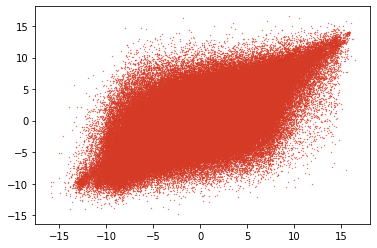

In [74]:
# transform each input image into the latent space
z = encoder.predict(x_test)

# plot the latent space
plt.scatter(z[:,0],z[:,1], marker='o', s=0.1, c='#d53a26')
plt.show()

In [97]:
filepath = "D:/ProjectsFolder/mmbr"
tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch')

KeyError: 'val_loss'

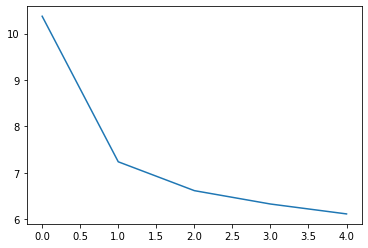

In [70]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [79]:
# plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

KeyError: 'val_acc'

In [ ]:
_ , auto = autoencoder()

In [99]:
auto.compile(loss='mse', # keras.losses.mean_squared_error
    optimizer=keras.optimizers.SGD(lr=0.2),)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = auto.fit(
    x_train, # input
    y_train, # output
    batch_size=256,
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=5,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))

AttributeError: 'Autoencoder' object has no attribute 'compile'

# another way

# Building Autoencoders

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten

class Autoencoder:
  def __init__(self, img_shape=(32,32,3), latent_dim=10, n_layers=2, n_units=128):
    if not img_shape: raise Exception('Please provide img_shape (height, width) in px')

    # create the encoder
   
    i = h = Input(img_shape) # the encoder takes as input images
    h = Flatten()(h) # flatten the image into a 1D vector
    for _ in range(n_layers): # add the "hidden" layers
    h = Dense(n_units)(h) # add the units in the ith hidden layer
    o = Dense(latent_dim)(h) # this layer indicates the lower dimensional size
    self.encoder = Model(inputs=[i], outputs=[o])

    # create the decoder
    i = h = Input((latent_dim,)) # the decoder takes as input lower dimensional vectors
    for _ in range(n_layers): # add the "hidden" layers
      h = Dense(n_units)(h) # add the units in the ith hidden layer
    h = Dense(img_shape[0] * img_shape[1]*img_shape[2])(h) # one unit per pixel in inputs
    o = Reshape(img_shape)(h) # create outputs with the shape of input images
    self.decoder = Model(inputs=[i], outputs=[o])

    # combine the encoder and decoder into a full autoencoder
    i = Input(img_shape) # take as input image vectors
    z = self.encoder(i) # push observations into latent space
    o = self.decoder(z) # project from latent space to feature space
    self.model = Model(inputs=[i], outputs=[o])
    self.model.compile(loss='mse', optimizer='adam')

autoencoder = Autoencoder()

# Building Autoencoders

In [29]:
autoencoder.model.fit(x_train, x_train, batch_size=64, epochs=8)

Epoch 1/8
50000/50000 [==============================] - 14s 287us/step - loss: 0.0312
Epoch 2/8
50000/50000 [==============================] - 10s 205us/step - loss: 0.0218
Epoch 3/8
50000/50000 [==============================] - 14s 289us/step - loss: 0.0218
Epoch 4/8
50000/50000 [==============================] - 14s 287us/step - loss: 0.0738
Epoch 5/8
50000/50000 [==============================] - 14s 285us/step - loss: 0.0247
Epoch 6/8
50000/50000 [==============================] - 14s 290us/step - loss: 0.0226
Epoch 7/8
50000/50000 [==============================] - 15s 293us/step - loss: 0.0216
Epoch 8/8
50000/50000 [==============================] - 14s 273us/step - loss: 0.0215


# Analyzing the Trained Autoencoder

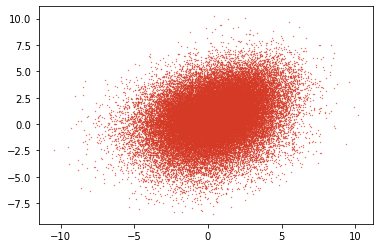

In [30]:
import matplotlib.pyplot as plt

# transform each input image into the latent space
z = autoencoder.encoder.predict(x_train)

# plot the latent space
plt.scatter(z[:,0], z[:,1], marker='o', s=0.1, c='#d53a26')
plt.show()

Sampling from the Latent Space

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


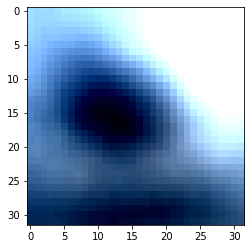

In [34]:
# sample from the region 10, 50 in the latent space
y = np.array([[9,8,7,4,5,6,3,2,1,0]])
prediction = autoencoder.decoder.predict(y)
plt.imshow(prediction.squeeze(), cmap='gray')